In [2]:
import tensorflow as tf
import keras
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import numpy as np
import pandas as pd
from collections import defaultdict
import re


import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dropout
from keras.models import Model

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3305547818233781280
]


Using TensorFlow backend.


In [3]:
def clean_str(string):
    """
    Cleaning of dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()


In [4]:
data_train = pd.read_csv('C:\\Users\\91998\\Downloads\\FInal Code\\train.csv')


In [5]:
# Input Data preprocessing
# data_train = pd.read_csv('C:\\Users\\Lenovo\\Desktop\\AI Project\\train.csv')
texts = []
labels = []

for i in range(data_train.text.shape[0]):
    text1 = data_train.title[i]
    text2 = data_train.text[i]
    text = str(text1) +""+ str(text2)
    texts.append(text)
    labels.append(data_train.label[i])
#Splits sentences into words
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

#Gives the index for each word in sentences
tokenizer.fit_on_texts(texts)

#
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
#print('Found %s unique tokens.' % len(word_index))

In [6]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (20800, 1000)
Shape of label tensor: (20800, 2)


In [7]:
# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( x_test, y_test, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 16640 2080 2080
real & fake news in train,valt,test:
[8298. 8342.]
[1058. 1022.]
[1031. 1049.]


In [8]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Dense, Embedding, LSTM, GRU

%matplotlib inline

In [12]:
#Using Pre-trained word embeddings
GLOVE_DIR = "C:\\Users\\91998\\Downloads\\FInal Code\\" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

Total 400000 word vectors in Glove.


In [13]:
embedding_vecor_length = 32
modell = Sequential()
modell.add(embedding_layer)
modell.add(Dropout(0.2))
modell.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
modell.add(BatchNormalization())
modell.add(Dense(256, activation='relu'))
modell.add(Dense(128, activation='relu'))
modell.add(Dense(64, activation='relu'))
modell.add(Dense(2, activation='softmax'))
modell.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modell.summary())
modell.fit(x_train, y_train, epochs=10, batch_size=64)

modell.save('lstm.h5')


W0122 19:53:20.376424  7604 deprecation_wrapper.py:119] From c:\users\91998\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         25187700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 32)          16032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 64)           6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)              

W0122 19:53:23.351107  7604 deprecation.py:323] From c:\users\91998\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0122 19:53:27.767991  7604 deprecation_wrapper.py:119] From c:\users\91998\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/10
16640/16640 [==============================] - 362s 22ms/step - loss: 0.4023 - accuracy: 0.8007
Epoch 2/10
16640/16640 [==============================] - 8264s 497ms/step - loss: 0.1979 - accuracy: 0.9196
Epoch 3/10
16640/16640 [==============================] - 270s 16ms/step - loss: 0.1049 - accuracy: 0.9606
Epoch 4/10
16640/16640 [==============================] - 265s 16ms/step - loss: 0.0493 - accuracy: 0.9829
Epoch 5/10
16640/16640 [==============================] - 268s 16ms/step - loss: 0.0268 - accuracy: 0.9897
Epoch 6/10
16640/16640 [==============================] - 253s 15ms/step - loss: 0.0177 - accuracy: 0.9939
Epoch 7/10
16640/16640 [==============================] - 242s 15ms/step - loss: 0.0139 - accuracy: 0.9952
Epoch 8/10
16640/16640 [==============================] - 259s 16ms/step - loss: 0.0082 - accuracy: 0.9971
Epoch 9/10
16640/16640 [==============================] - 249s 15ms/step - loss: 0.0076 - accuracy: 0.9975
Epoch 10/10
16640/16640 [==========

In [39]:
# updated LSTM
embedding_vecor_length = 32
modell = Sequential()
modell.add(embedding_layer)
modell.add(Dropout(0.4))
modell.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
# modell.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
# modell.add(MaxPooling1D(pool_size=2))
modell.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
modell.add(BatchNormalization())
# modell.add(Dense(128, activation='relu'))
# modell.add(Dense(64, activation='relu'))
modell.add(Dense(32, activation='relu'))
modell.add(Dense(2, activation='softmax'))
modell.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modell.summary())
# history = modell.fit(x_train, y_train, epochs=3, batch_size=64)
history = modell.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=3, batch_size=128)
modell.save('lstm.h5')


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         25187700  
_________________________________________________________________
dropout_13 (Dropout)         (None, 1000, 100)         0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 1000, 64)          19264     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 500, 64)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_13 (Batc (None, 64)                256       
_________________________________________________________________
dense_34 (Dense)             (None, 32)              

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


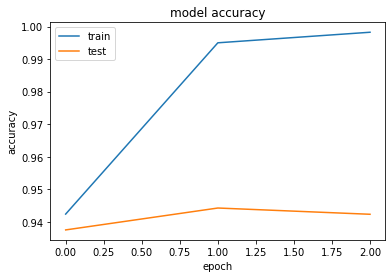

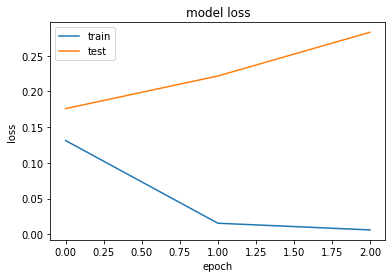

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Correct predictions: 2008.0
Total number of test examples: 2080
Accuracy of model1:  0.9653846153846154


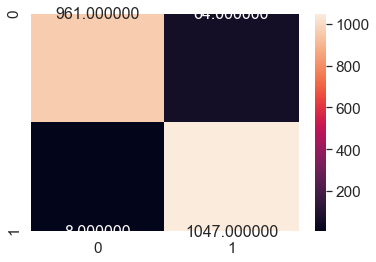

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
test_preds = modell.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = modell.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
# plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
# plt.title('Confusion matrix - model1')
# plt.colorbar()
# plt.ylabel('expected label')
# plt.xlabel('predicted label')
# plt.show()
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm,annot=True,annot_kws={"size": 16},fmt='1f')# font size